In [36]:
# ------------------------------------------------------------
# 🔧 Sistema y utilidades
# ------------------------------------------------------------
import os
import time
import random
import zipfile
import urllib

# ------------------------------------------------------------
# 🔢 Cálculo numérico y científico
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter
from math import log10

# ------------------------------------------------------------
# 🎨 Visualización
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 🖼️ Procesamiento de imágenes
# ------------------------------------------------------------
from PIL import Image
from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 🧠 Machine Learning / Deep Learning
# ------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchsummary import summary

# ------------------------------------------------------------
# 🌀 Librerías adicionales para operadores y modelos avanzados
# ------------------------------------------------------------
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm

# ------------------------------------------------------------
# 📦 Librerías del paquete The Well
# ------------------------------------------------------------
from the_well.data import WellDataset
from the_well.benchmark.metrics import VRMSE
from the_well.utils.download import well_download

# ------------------------------------------------------------
# 🖼️ Vision por computador (torchvision)
# ------------------------------------------------------------
from torchvision import datasets, transforms
# ------------------------------------------------------------



In [37]:
# ------------------------------------------------------------
# 0) Device setup
# ------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

if device == "cuda":
    print(f"✅ Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ CUDA no disponible, usando CPU.")

✅ Device: NVIDIA GeForce RTX 4090


## Exploratory analysis

In [3]:
# 1) Load dataset
# ------------------------------------------------------------
dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=81,
    n_steps_output=0,
    use_normalization=True,

)

print(len(dataset))



175


In [4]:
dataset.metadata.field_names

{0: ['concentration'],
 1: ['velocity_x', 'velocity_y'],
 2: ['D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']}

In [5]:
item = dataset[0]
print(item.keys())
print(item['input_fields'].shape)

dict_keys(['input_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid'])
torch.Size([81, 256, 256, 11])


In [6]:
idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)



DIVISION TRAN/TEST DATA

In [7]:
print(train_idx.shape, test_idx.shape)

(140,) (35,)


TRAIN DATA

In [8]:
print(train_idx)

[118 143 164  38 135 104  67 148   2  98 152 159  75 108  26 161  90 115
  69  36  85  22 144  96  68 168  11  97  76   6  27  82   4  32  93 120
 166  10 171 122   0 132 124  64  44  95  28  40 125  25  23 142  81  79
  84  39 100  86 119 170 147  47  94 133 163  61  73  33 123 136 137  62
 173 111 114 105  53   5 157   3 162  49  35  80  77  34  46   7  43  70
 140 110  91  83 154 158  89   8  13  59 150 131  17  72 153 134 146 160
  63  54 107  50 172  58  48  88  21  57 169 129  37 165   1  52 149 130
 151 103  99 116  87  74 121 174  20  71 106  14  92 102]


EXPLORATORY DATA

torch.Size([81, 256, 256, 11])


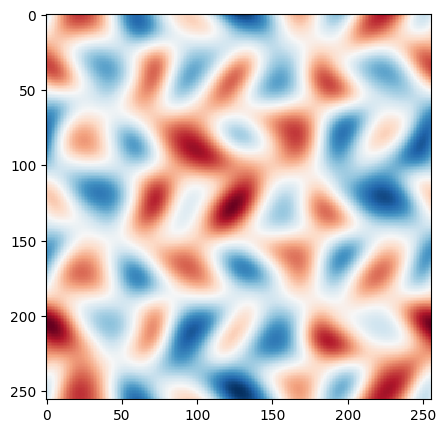

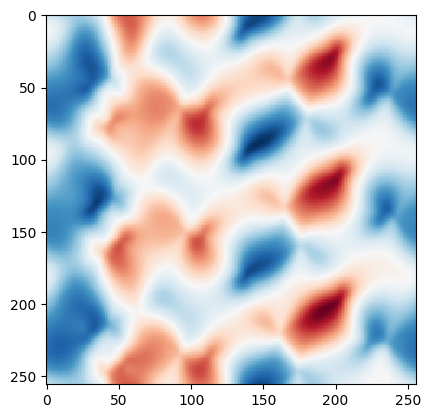

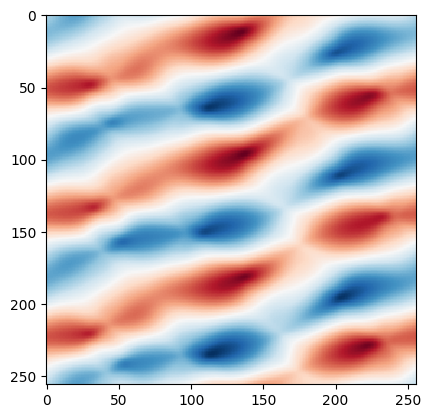

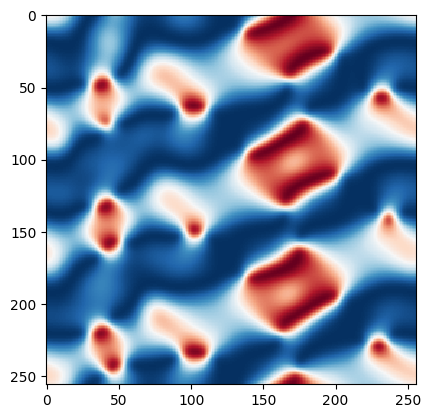

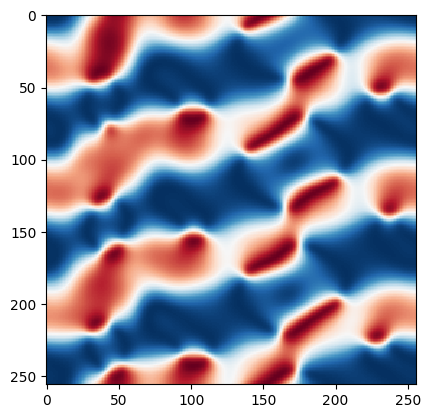

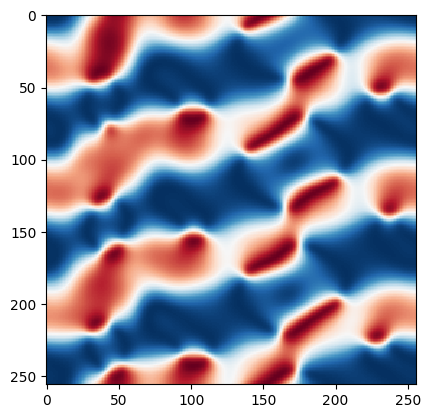

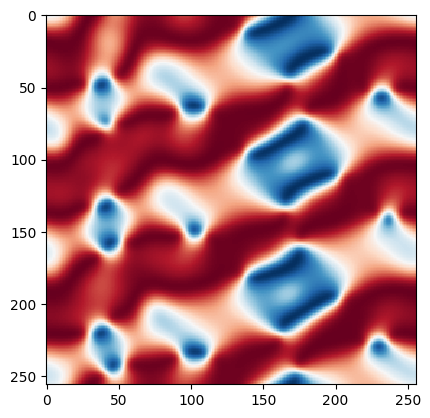

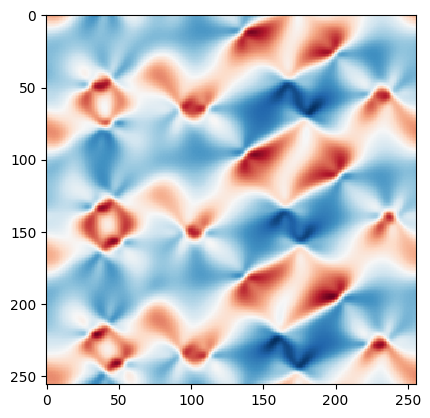

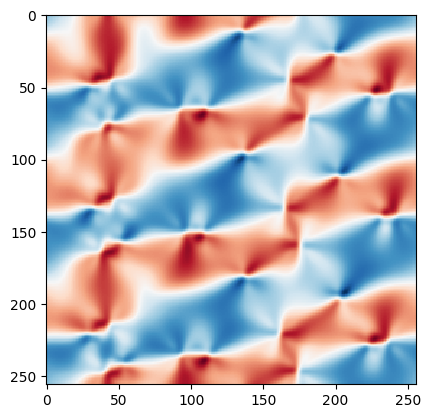

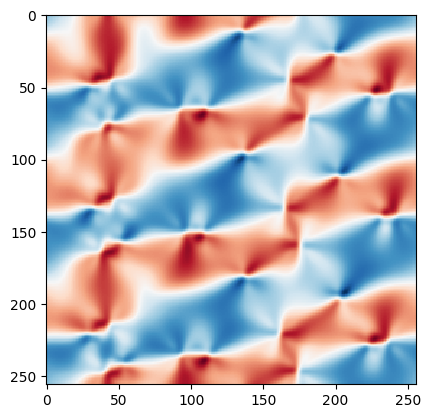

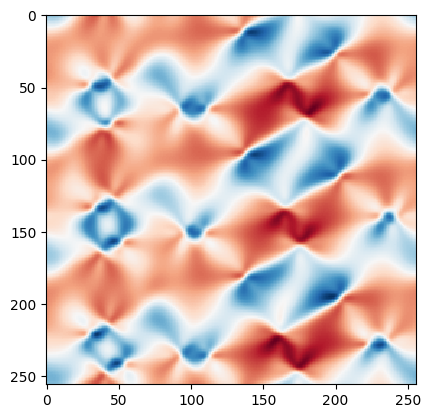

In [9]:

x = dataset[train_idx[0]]['input_fields']
print(x.shape)
T, Lx, Ly, F = x.shape
ti = 10

plt.figure(figsize=(15, 5))
for i in range(11):
    img = x[ti,:,:, i] 
    vmin = np.nanmin(img)
    vmax = np.nanmax(img)
    plt.imshow(img,cmap="RdBu_r",interpolation="none",vmin=vmin,vmax=vmax)
    plt.show()

FEATURE CALCULATION

In [10]:


N = len(train_idx)
T = 81

mc = np.zeros((N, T), dtype=np.float32)
Ke = np.zeros((N, T), dtype=np.float32)
S = np.zeros((N, T), dtype=np.float32)
Srm = np.zeros((N, T), dtype=np.float32)
N_o = np.zeros((N, T), dtype=np.float32)
C_c = np.zeros((N, T), dtype=np.float32)

for i in range(N):

    item = dataset[train_idx[i]]
    x    = item['input_fields']  

    for t in range(T):
        c  = x[t, :, :, 0].mean()

        vx = x[t, :, :, 1]
        vy = x[t, :, :, 2]
        ke = 0.5 * ( (vx**2 + vy**2).mean() )

        dxx = x[t, :, :, 3]
        dxy = x[t, :, :, 4]
        dyx = x[t, :, :, 5]
        dyy = x[t, :, :, 6]
        Si = ((dxx*vy - dyy*vx)**2).mean()

        Exx = x[t, :, :, 7]
        Exy = x[t, :, :, 8]
        Eyx = x[t, :, :, 9]
        Eyy = x[t, :, :, 10]
        smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
        no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()

        cc = (vx*dxx + vy*dyx).mean()

        mc[i, t] = c
        Ke[i, t] = ke
        S[i,t] = Si
        Srm[i,t] = smr
        N_o[i,t] = no
        C_c[i,t] = cc

/tmp/ipykernel_17410/602541751.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
/tmp/ipykernel_17410/602541751.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()


HISTOGRAM FOR EACH FEATURE ACRROS THE NUMBER OF SIMULATIONS:
we need to choose the time 

In [11]:
from ipywidgets import interact

def plot_hists(T):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))

    ax[0].hist(Ke[:, T], bins=30)
    ax[0].set_title(f"Ke[:, {T}]")

    ax[1].hist(S[:, T], bins=30)
    ax[1].set_title(f"S[:, {T}]")

    ax[2].hist(Srm[:, T], bins=30)
    ax[2].set_title(f"Srm[:, {T}]")
    plt.tight_layout()
    plt.show()

interact(plot_hists, T=(0, Ke.shape[1]-1))

interactive(children=(IntSlider(value=40, description='T', max=80), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_hists(T)>

In [12]:
def plot_hists(T):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    ax[0].hist(N_o[:, T], bins=30)
    ax[0].set_title(f"N_o[:, {T}]")

    ax[1].hist(C_c[:, T], bins=30)
    ax[1].set_title(f"C_c[:, {T}]")

    plt.tight_layout()
    plt.show()

interact(plot_hists, T=(0, Ke.shape[1]-1))

interactive(children=(IntSlider(value=40, description='T', max=80), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_hists(T)>

In [13]:

T = np.linspace(0,80,81,dtype=int)
   
def plot(n_s):
    fig, ax = plt.subplots(1, 4, figsize=(12,4))


    ax[0].plot(T,mc[n_s, :])
    ax[0].set_title(f"mc[{n_s},:]")

    ax[1].plot(T,Ke[n_s, :])
    ax[1].set_title(f"Ke[{n_s},:]")

    ax[2].plot(T,S[n_s, :])
    ax[2].set_title(f"S[{n_s},:]")

    ax[3].plot(T,Srm[n_s, :])
    ax[3].set_title(f"Srm[{n_s},:]")

    plt.tight_layout()
    plt.show()

interact(plot, n_s=(0, Ke.shape[0]-1))

interactive(children=(IntSlider(value=69, description='n_s', max=139), Output()), _dom_classes=('widget-intera…

<function __main__.plot(n_s)>

In [14]:

   
def plot(n_s):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))


    ax[0].plot(T,N_o[n_s, :])
    ax[0].set_title(f"N_o[{n_s},:]")

    ax[1].plot(T,C_c[n_s, :])
    ax[1].set_title(f"C_c[{n_s},:]")

    plt.tight_layout()
    plt.show()

interact(plot, n_s=(0, Ke.shape[0]-1))

interactive(children=(IntSlider(value=69, description='n_s', max=139), Output()), _dom_classes=('widget-intera…

<function __main__.plot(n_s)>

AUTOENCODER

In [38]:
dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=1,
    n_steps_output=0,
    use_normalization=True,

)

In [39]:
print(len(dataset))
item = dataset[0]
print(item['input_fields'].shape)  


14175
torch.Size([1, 256, 256, 11])


In [40]:
idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)
print(train_idx)
print(test_idx)

[4096 1219 5076 ... 5390  860 7270]
[ 2315  9096  5169 ...  1830 13854    85]


AUTOENCODER 2D


Step 2: Loading the Dataset


In [41]:


loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)



In [42]:
total = len(dataset)
train_size = int(0.8 * total)
eval_size = total - train_size

# División
# train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

g = torch.Generator().manual_seed(42)

train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size], generator=g)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
eval_loader  = torch.utils.data.DataLoader(eval_dataset,  batch_size=256, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Eval samples:  {len(eval_dataset)}")

Train samples: 11340
Eval samples:  2835


In [20]:
train_loader.dataset[0]['input_fields'].shape

torch.Size([1, 256, 256, 11])

In [21]:
eval_loader.dataset[0]['input_fields'].shape

torch.Size([1, 256, 256, 11])

In [22]:
dataset[0]['input_fields'].shape

torch.Size([1, 256, 256, 11])

Step 3: Define the Autoencoder Model

In this step we are going to define our autoencoder. It consists of two components:

Encoder: Compresses the 784-pixel image into a smaller latent representation through fully connected layers with ReLU activations helps in reducing dimensions.

256*256*11 = 720896 ==> 128 ==> 64 ==> 36 ==> 18 ==> 9


Decoder: Reconstructs the original image by expanding the latent vector back to the original size, ending with a Sigmoid activation to output pixel values between 0 and 1

9 ==> 18 ==> 36 ==> 64 ==> 128 ==> 720896 ==> 256*256*11 = 720896

In [23]:
# class AE(nn.Module):               # clase llamada Autoencoder que hereda de nn.Module, que es la clase base de todos los modelos en PyTorch
#     def __init__(self):                     #	•	__init__: es el constructor de la clase, donde defines las capas del modelo.
#         super(AE, self).__init__() #	super(Autoencoder, self).__init__() llama al constructor de nn.Module para que PyTorch pueda manejar bien los parámetros del modelo (guardar pesos, mover a GPU, etc.).
#         self.encoder = nn.Sequential(       # nn.Sequential agrupa capas una detrás de otra.
#             nn.Conv2d(11, 16, 3, stride=1, padding=1),      # Entrada: 11 canales (por ejemplo, una imagen con 11 bandas/variables).  Salida: 16 canales (más “filtros”/features). Kernel: 3x3 stride=1: se mueve de a un pixel
#                                                             # padding=1: añade 1 píxel de borde para que la altura/anchura se mantengan iguales.
#             nn.ReLU(),                      # Aplica la función no lineal ReLU: relu(x) = max(0, x) para introducir no linealidad.
#             nn.MaxPool2d(2, stride=2),      # 	Toma ventanas de 2x2 stride=2: reduce la resolución a la mitad.
#             nn.Conv2d(16, 8, 3, stride=1, padding=1), # segunda convolucion, Entrada: 16 canales. Salida: 8 canales. Kernel 3x3, stride 1, padding 1 → misma H y W. (batch, 16, H/2, W/2) → (batch, 8, H/2, W/2)
#             nn.ReLU(),
#             nn.MaxPool2d(2, stride=2)       # De nuevo reduce a la mitad: (batch, 8, H/2, W/2) → (batch, 8, H/4, W/4)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(8, 16, 3, stride=2,
#                                padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 11, 3, stride=2,
#                                padding=1, output_padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         z = self.encoder(x)   # representación latente
#         xr = self.decoder(z)  # reconstrucción
#         return xr, z

# # En CNNs es súper normal que:
# # 	•	A medida que bajas la resolución espacial (por el pooling),
# # 	•	subas el nº de canales para capturar patrones más complejos.

In [43]:
class AE(nn.Module):
    def __init__(self, latent_dim=8):
        super(AE, self).__init__()

        # -------------- ENCODER --------------
        self.encoder_conv = nn.Sequential(
            # 256 -> 128
            nn.Conv2d(11, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 128 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 64 -> 32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 256 → 128 → 64 → 32
        )
        # Ahora la forma es (B, 128, 32, 32)
        self.enc_out_channels = 128
        self.enc_out_h = 32
        self.enc_out_w = 32
        enc_flat_dim = self.enc_out_channels * self.enc_out_h * self.enc_out_w

        # Cuello de botella (vector latente)
        self.fc_enc = nn.Linear(enc_flat_dim, latent_dim)

        # -------------- DECODER --------------
        self.fc_dec = nn.Linear(latent_dim, enc_flat_dim)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,
                               padding=1, output_padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,
                               padding=1, output_padding=1),  # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 11, kernel_size=3, stride=2,
                               padding=1, output_padding=1),  # 128 -> 256
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_conv(x)                  # (B, 128, 32, 32)
        h = h.view(x.size(0), -1)                 # (B, enc_flat_dim)
        z = self.fc_enc(h)                        # (B, latent_dim)
        return z

    def decode(self, z):
        h = self.fc_dec(z)                        # (B, enc_flat_dim)
        h = h.view(-1, self.enc_out_channels,
                   self.enc_out_h, self.enc_out_w)  # (B, 128, 32, 32)
        xr = self.decoder_conv(h)                 # (B, 11, 256, 256)
        return xr

    def forward(self, x):
        z = self.encode(x)
        xr = self.decode(z)
        return xr, z

Step 4: Initializing Model

After defining the autoencoder, we create an instance of the model. We use Mean Squared Error (MSE) as the loss function since it measures how close the reconstructed images are to the original inputs. For optimization, we use the Adam optimizer with a learning rate of 0.001 and weight decay of 10e-8 which helps to prevent overfitting.

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Step 5: Training the model and Plotting Training Loss

In this step the model undergoes training for 20 epochs. The training process updates the model's weights using backpropagation and optimization techniques. Loss values are recorded during each iteration and after training a loss plot is generated to assess the model’s performance over time.

for batch in loader
Lee los datos por lotes
model(x)
Calcula la reconstrucción
loss = MSE(xr, x)
Mide el error de reconstrucción
loss.backward()
Calcula gradientes
optimizer.step()
Actualiza pesos
running += loss.item()
Acumula el error
epoch_loss = running / len(loader)
Promedia el error del epoch
losses.append(epoch_loss)
Guarda para graficar
plt.plot(losses)
Muestra la convergencia


Epoch 1/20 | Train Loss: 0.200972 | Val Loss: 0.161657
Epoch 2/20 | Train Loss: 0.164112 | Val Loss: 0.160785
Epoch 3/20 | Train Loss: 0.163005 | Val Loss: 0.160428
Epoch 4/20 | Train Loss: 0.162583 | Val Loss: 0.159912
Epoch 5/20 | Train Loss: 0.161843 | Val Loss: 0.158665
Epoch 6/20 | Train Loss: 0.159916 | Val Loss: 0.156351
Epoch 7/20 | Train Loss: 0.155632 | Val Loss: 0.151418
Epoch 8/20 | Train Loss: 0.152366 | Val Loss: 0.148923
Epoch 9/20 | Train Loss: 0.149867 | Val Loss: 0.146872
Epoch 10/20 | Train Loss: 0.147948 | Val Loss: 0.145502
Epoch 11/20 | Train Loss: 0.146073 | Val Loss: 0.143208
Epoch 12/20 | Train Loss: 0.142807 | Val Loss: 0.139919
Epoch 13/20 | Train Loss: 0.140810 | Val Loss: 0.138749
Epoch 14/20 | Train Loss: 0.139660 | Val Loss: 0.138254
Epoch 15/20 | Train Loss: 0.139131 | Val Loss: 0.137819
Epoch 16/20 | Train Loss: 0.138656 | Val Loss: 0.137476
Epoch 17/20 | Train Loss: 0.138275 | Val Loss: 0.137196
Epoch 18/20 | Train Loss: 0.138355 | Val Loss: 0.137081
E

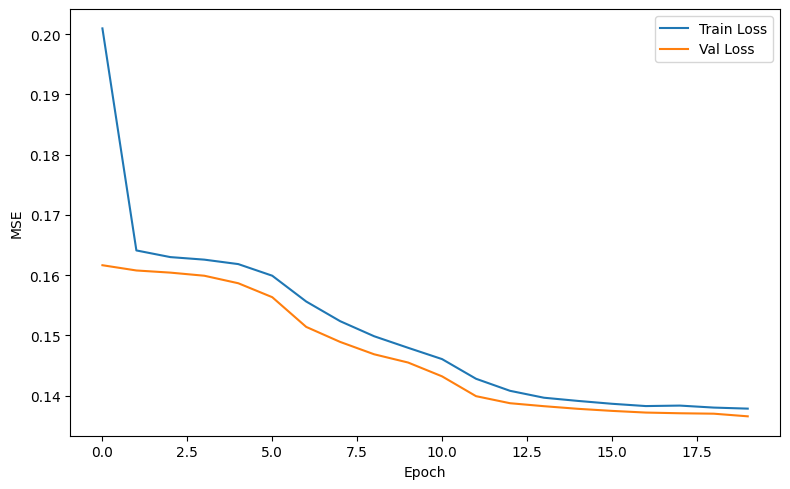

In [28]:
epochs = 20
train_losses = []
val_losses = []
patience = 5  

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # -----------------------
    # Fase de ENTRENAMIENTO
    # -----------------------
    model.train()
    running_train = 0.0

    for batch in train_loader:
        # batch["input_fields"]: (B, 1, 256, 256, 11)
        x = batch["input_fields"].to(device)

        # quitar la dimensión de tiempo (n_steps_input=1)
        x = x[:, 0]  # (B, 256, 256, 11)

        # reordenar a (B, C, H, W) = (B, 11, 256, 256)
        x = x.permute(0, 3, 1, 2).contiguous()

        # forward
        xr, z = model(x)

        # loss
        loss = criterion(xr, x)

        # backward
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running_train += loss.item()

    epoch_train_loss = running_train / len(train_loader)
    train_losses.append(epoch_train_loss)

    # -----------------------
    # Fase de VALIDACIÓN
    # -----------------------
    model.eval()
    running_val = 0.0

    with torch.no_grad():
        for batch in eval_loader:
            x = batch["input_fields"].to(device)
            x = x[:, 0]                       # (B, 256, 256, 11)
            x = x.permute(0, 3, 1, 2).contiguous()  # (B, 11, 256, 256)

            xr, z = model(x)
            val_loss = criterion(xr, x)
            running_val += val_loss.item()

    epoch_val_loss = running_val / len(eval_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.6f} | "
          f"Val Loss: {epoch_val_loss:.6f}")


        # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# -----------------------
# Curvas de pérdida
# -----------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# -----------------------------------
# 5) Guardar el modelo entrenado
# -----------------------------------
torch.save(model.state_dict(), "autoencoder_active_matter2.pth")
print("✅ Modelo guardado como 'autoencoder_active_matter2.pth'")

✅ Modelo guardado como 'autoencoder_active_matter2.pth'


In [45]:
model = AE()
model.load_state_dict(torch.load("autoencoder_active_matter2.pth"))
model.to(device)
model.eval()

AE(
  (encoder_conv): Sequential(
    (0): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_enc): Linear(in_features=131072, out_features=8, bias=True)
  (fc_dec): Linear(in_features=8, out_features=131072, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32

In [86]:
import gc
gc.collect()
torch.cuda.empty_cache()
#del model
#del train_dataset
del eval_dataset

In [88]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            if obj.is_cuda:
                print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([256, 11, 256, 256])


/home/itachi/miniconda3/envs/ml/lib/python3.10/site-packages/torch/__init__.py:1136: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/tmp/ipykernel_17410/3102666465.py:3: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
2025-11-20 20:58:48.317241: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 20:58:48.743673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, i

<class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 11, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([11])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.Tensor'> torch.Size([32, 11, 3, 3])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([64, 32, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([128, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([8, 131072])
<class 'torch.Tensor'> torch.Size([8])
<class 'torch.Tensor'> torch.Size([131072, 8])
<class 'torch.Tensor'> torch.Size([131072])
<class 'torch.Tensor'> torch.Size([128, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 32, 3, 3])
<clas

In [87]:
xti = []
xto = []
with torch.no_grad():
    for batch in eval_loader:
        x = batch["input_fields"].to(device)
        x = x[:, 0]                       # (B, 256, 256, 11)
        x = x.permute(0, 3, 1, 2).contiguous()  # (B, 11, 256, 256)
        xti.append(x)
        xr, z = model(x)
        xto.append(xr)
        val_loss = criterion(xr, x)




NameError: name 'model' is not defined

In [68]:
print(x.shape, xr.shape)

torch.Size([19, 11, 256, 256]) torch.Size([19, 11, 256, 256])


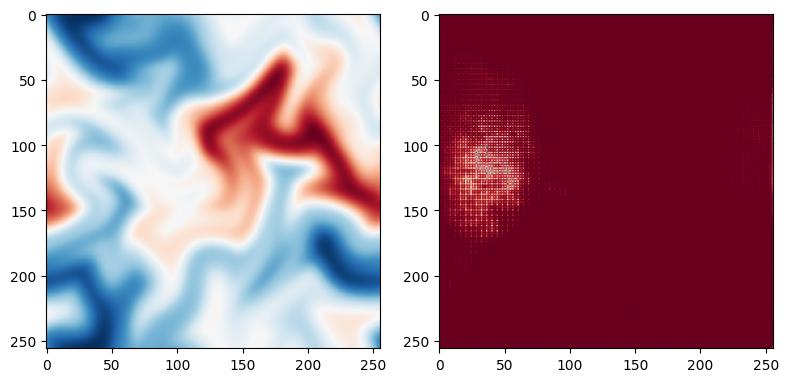

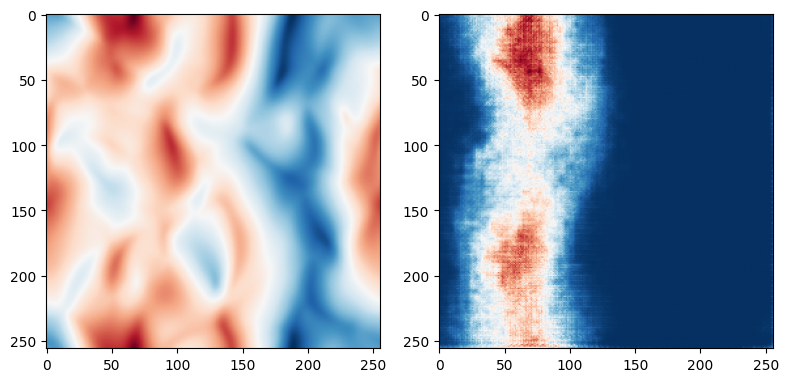

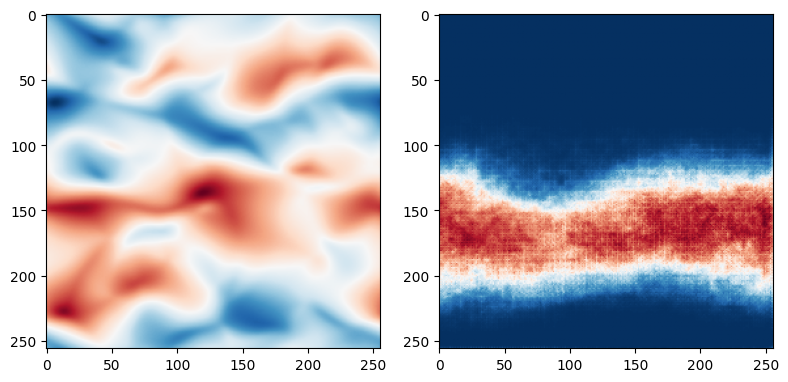

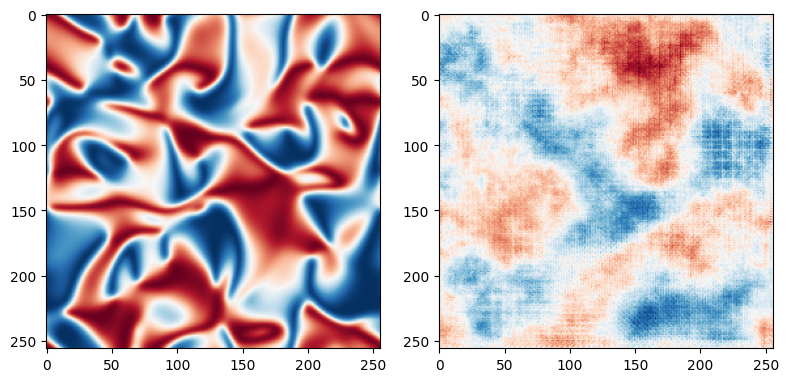

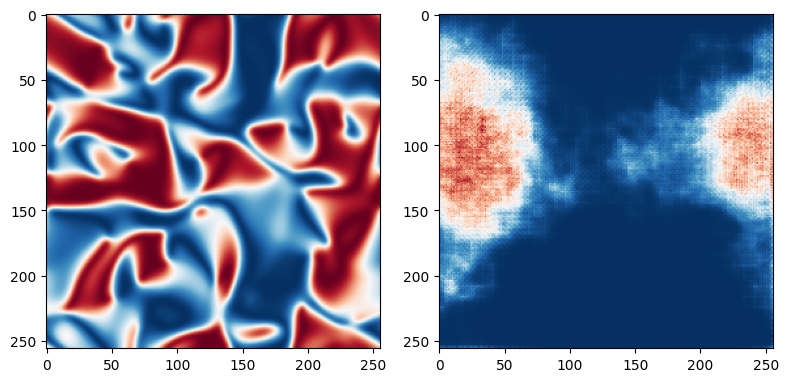

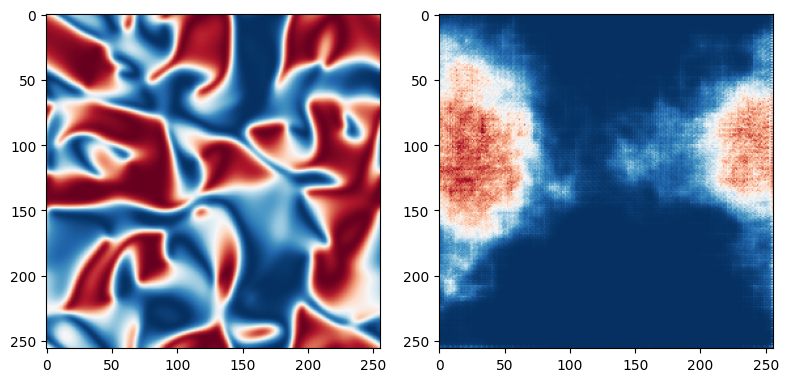

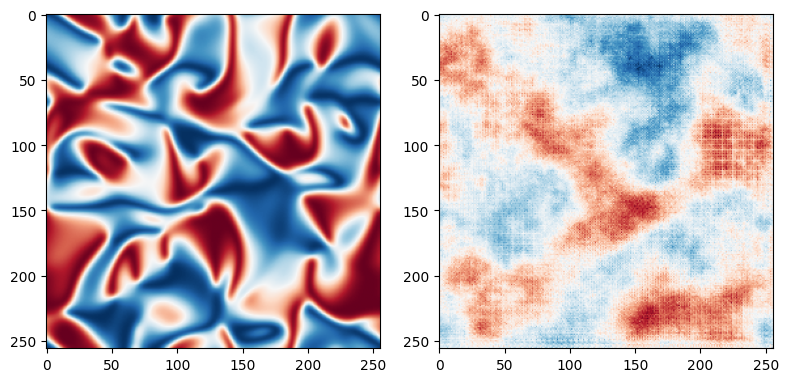

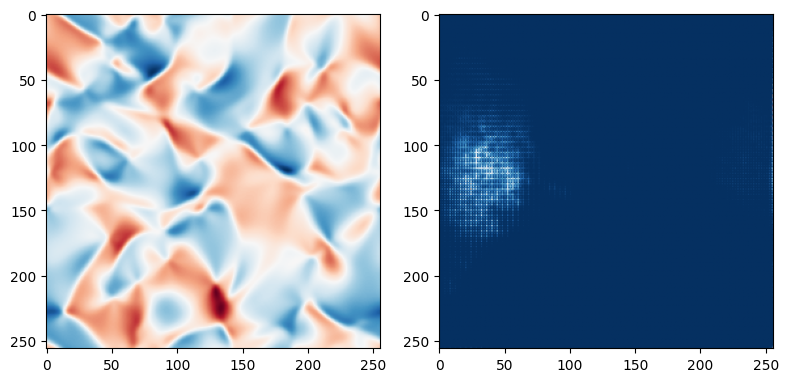

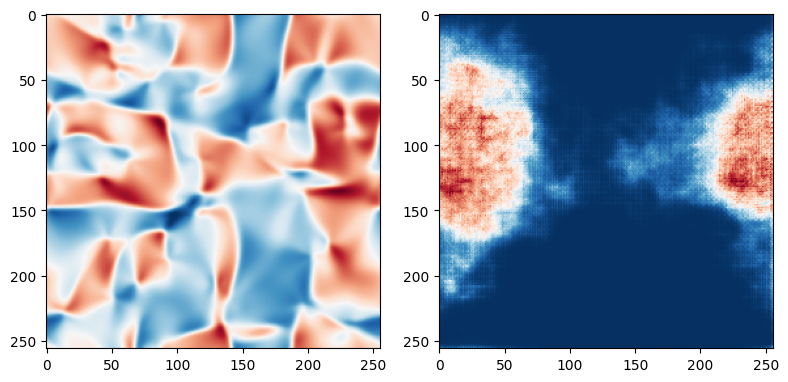

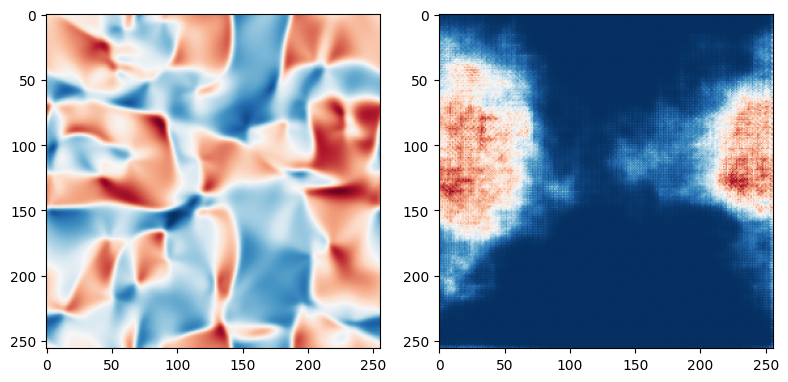

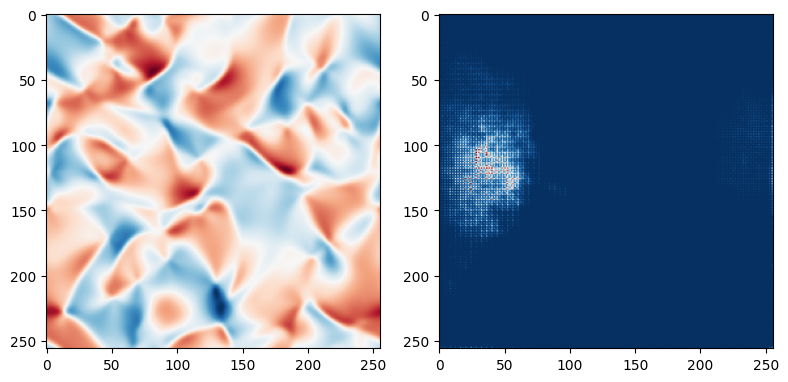

In [70]:
for i in range(11):
    img = x[18,i,:,:].detach().cpu().numpy() 
    imgr = xr[18,i,:,:].detach().cpu().numpy() 
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img,cmap="RdBu_r")

    plt.subplot(1,2,2)
    plt.imshow(imgr,cmap="RdBu_r")

    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow()

In [31]:
# import torch
# import numpy as np

# model.eval()  # modo evaluación (desactiva dropout, etc.)
# Z = []        # lista donde guardaremos todos los vectores latentes

# with torch.no_grad():  # sin gradientes = más rápido y menos memoria
#     for batch in loader:
#         x = batch["input_fields"].to(device)   # (B, 1,256,256,11)
#         _, z = model(x)                        # obtenemos la salida latente
#         Z.append(z.detach().cpu().numpy())     # pasamos a numpy y CPU

# # concatenar todos los lotes
# Z = np.concatenate(Z, axis=0)  # (N, 9)
# print("Espacio latente total:", Z.shape)

# # guardar a disco
# np.save("latent_space.npy", Z)
# print("Espacio latente guardado en latent_space.npy")

In [32]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1) Extraer latentes del dataset completo
model.eval()
Z = []
PARAM = []   # opcional: para colorear por un parámetro físico

with torch.no_grad():
    for batch in loader:
        x = batch["input_fields"].to(device)       # (B, 1,256,256,11)
        xr, z = model(x)                           # z: (B, 9)
        Z.append(z.detach().cpu().numpy())

        # opcional: guarda un escalar para color (ej. alpha en índice 0)
        if "constant_scalars" in batch:
            # shape típico: (B, n_scalars). Ajusta el índice según tu dataset
            PARAM.append(batch["constant_scalars"][:, 0].cpu().numpy())

Z = np.concatenate(Z, axis=0)                      # (N, 9)
PARAM = np.concatenate(PARAM, axis=0) if PARAM else None

print("Latent matrix Z shape:", Z.shape)

# 2) (Recomendado) estandarizar latentes antes de PCA
scaler = StandardScaler()
Z_std = scaler.fit_transform(Z)

# 3) PCA a 2 dimensiones (para plot rápido)
pca2 = PCA(n_components=2, random_state=0)
Z2 = pca2.fit_transform(Z_std)
print("Explained variance ratio (2D):", pca2.explained_variance_ratio_)

plt.figure(figsize=(6,5))
if PARAM is not None:
    sc = plt.scatter(Z2[:,0], Z2[:,1], s=5, c=PARAM)  # sin colores fijos
    cbar = plt.colorbar(sc)
    cbar.set_label("alpha (ejemplo)")
else:
    plt.scatter(Z2[:,0], Z2[:,1], s=5)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA del espacio latente (dim=9 → 2)")
plt.tight_layout()
plt.show()

# 4) (Opcional) PCA a 3D
pca3 = PCA(n_components=3, random_state=0)
Z3 = pca3.fit_transform(Z_std)
print("Explained variance ratio (3D):", pca3.explained_variance_ratio_)

# 5) (Opcional) guardar a disco
np.save("latent_Z.npy", Z)            # latentes originales (sin escalar)
np.save("latent_Z_pca2.npy", Z2)      # proyección 2D
if PARAM is not None:
    np.save("latent_param.npy", PARAM)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [256, 1, 256, 256, 11]